**Попытка сформировать финальный результат с использованием графов**

In [192]:
import osmnx as ox
import networkx as nx

fltr1 = ('["building" ~ "warehouse"]')
fltr2 = ('["industrial" ~ "port"]')
fltr3 = ('["landuse" ~ "railway"]')
fltr4 = ('["aeroway" ~ "."]')
G = ox.graph_from_place('Saint Petersburg', network_type='drive', simplify=False, retain_all=True)
G1 = ox.graph_from_place('Saint Petersburg', simplify=False, retain_all=True, custom_filter=fltr1)
G2 = ox.graph_from_place('Saint Petersburg', simplify=False, retain_all=True, custom_filter=fltr2)
G3 = ox.graph_from_place('Saint Petersburg', simplify=False, retain_all=True, custom_filter=fltr3)
G4 = ox.graph_from_place('Saint Petersburg', simplify=False, retain_all=True, custom_filter=fltr4)
full_graph = nx.compose_all([G, G1, G2, G3, G4])
full_graph_without_G = nx.compose_all([G1, G2, G3, G4])
# ox.plot_graph(full_graph)

In [210]:
gdf_nodes, gdf_relationships = ox.graph_to_gdfs(full_graph_without_G)
gdf_relationships.dropna(subset=['name']).drop_duplicates(subset=['name']).sample(2)

,,,osmid,oneway,reversed,length,name,ref,landuse,width,highway,geometry
u,v,key,,,,,,,,,,
6441521944,6441521947,0,687227555,False,False,54.958,Комсомольский парк,NaN,railway,NaN,NaN,"LINESTRING (30.36299 59.91669, 30.36316 59.91621)"
2906201954,2906201955,0,286953413,False,False,4.134,Покатушкин,NaN,NaN,NaN,NaN,"LINESTRING (30.39663 60.01099, 30.39656 60.01100)"


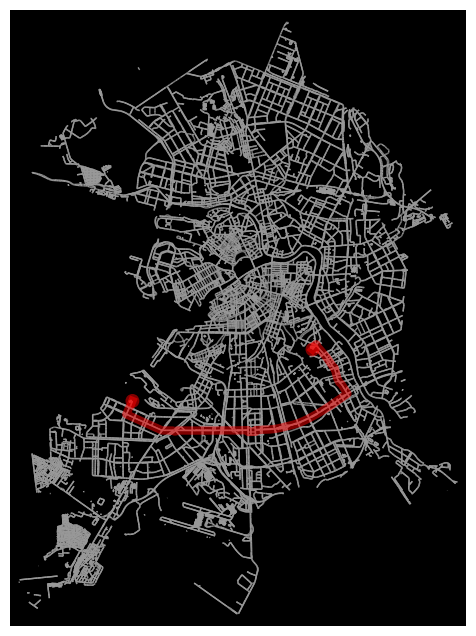

In [212]:
route = nx.shortest_path(full_graph, 1837026892, 1868751365)
fig, ax = ox.plot_graph_route(full_graph, route, route_linewidth=6, node_size=0, bgcolor='k')

____

**Попытка построить граф из взятых фич**

In [97]:
import osmnx as ox
import pandas as pd

def func(x):
    return x[0]

def func_1(x):
    gdf_1 = ox.geocode_to_gdf(x, by_osmid=True)
    return gdf_1[['lat', 'lon']]

def func_tags(tags, city):
    gdf = ox.features_from_place(city, tags)
    gdf = gdf[['name', 'geometry', 'nodes']]
    gdf = gdf.dropna().reset_index()
    gdf['n_osmid'] = gdf['element_type'].apply(func) + gdf['osmid'].astype(str)
    ex = [gdf['n_osmid'].apply(func_1).iloc[:].values[x] for x in range(len(gdf))]
    dfs = pd.concat(ex, axis=0).reset_index(drop=True)
    gdf = gdf.merge(dfs, on=dfs.index)
    gdf = gdf.drop('key_0', axis=1)
    gdf = gdf[['name', 'lat', 'lon', 'geometry', 'nodes']]
    gdf['kind_of'] = list(tags.keys())[0]
    return gdf

city = 'Saint Petersburg'
tags_port = {'port' : 'cargo'}
tags_aeroway = {'aeroway' : ['aerodrome','heliport', 'airstrip']}
tags_landuse = {'landuse' : 'railway'}
tags_build = {'building' : 'warehouse', 'amenity' : 'mailroom'}
full_df = pd.concat([func_tags(tags_port, city), func_tags(tags_aeroway, city), func_tags(tags_landuse, city), func_tags(tags_build, city)], ignore_index=True)

G = ox.graph_from_place("Saint Petersburg", retain_all=True, simplify = True, network_type='drive')
lat = list(full_df['lat'].values)
lon = list(full_df['lon'].values)
full_df['new_nodes'] = ox.distance.nearest_nodes(G, lon, lat)
full_df.head()

,name,lat,lon,geometry,nodes,kind_of,new_nodes
0,Третья стивидорная компания,59.878970,30.213249,"POLYGON ((30.20885 59.88225, 30.20867 59.88216...","[1495854450, 1495854446, 1495854443, 149585441...",port,2496692141
1,Нева-Металл,59.884243,30.203732,"POLYGON ((30.21001 59.88024, 30.21024 59.88037...","[1495854361, 1495854367, 1495854405, 149585443...",port,2930268667
2,Первый Контейнерный Терминал,59.879917,30.205881,"POLYGON ((30.21649 59.87602, 30.21588 59.87632...","[29003159, 29003160, 29003162, 1546437843, 149...",port,2496692141
3,Первая стивидорная компания,59.900097,30.223462,"POLYGON ((30.23869 59.91024, 30.23647 59.90991...","[1496678744, 1496678741, 1496678737, 149667873...",port,6781558006
4,Петербургский нефтяной терминал,59.883287,30.175183,"POLYGON ((30.16799 59.88702, 30.16898 59.88680...","[[[29003480, 29003481, 29003482, 7709497986, 7...",port,2590560444


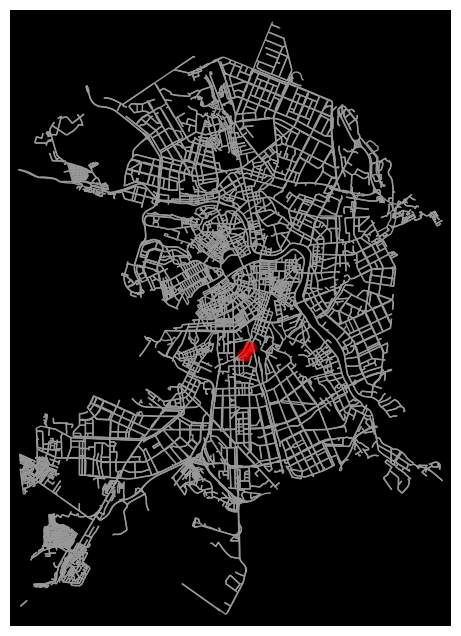

In [154]:
route = nx.shortest_path(G, 219808, 219811)
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')